# Diversity of Wikipedia article references

## Mining massive databases course final project

### Motivation and goals

The diversity of resources and content matters. When people are obtaining new knowledge, they don't want to be fooled with fake news or believe in information without proof from other authorized source. Sometimes Wikipedia articles may have poorly filled or unreferenced information, so, in the era of exponential data growth and post-truth, there is a huge need in automatic detection of articles with deficit of sources.


Our solution may help readers — to be more confident or sceptic about the information gained, as well as editors — such that they concentrate on the most important gaps of the article.

Moreover, noteworthy that there exist differences in the same article across different languages, that can be detected with our solution and fixed. 

### Problem statement

Estimate the quality of the article, based on the references, in an unsupervised way. Unite and check the results of our modeling with results from ORES model. 

![problem_statement](assets/clusters_w.png)

### Work pipeline

*First we'll import prepared modules:*

In [9]:
import os
import sys
sys.path.insert(0, "1_data_collection")
sys.path.insert(0, "2_feature_engineering")
sys.path.insert(0, "3_modeling")
from xml_to_csv import process_dumps
from csv_to_features import create_features
from features_to_clusters import get_clusters
from test import test_article

So the workin pipeline is this. We've done for the English Wikipedia.

![pipeline](assets/pipeline_w.png)

### Data processing

* Download wikipedia XML dumps:
    * We are using page article multistream dumps. To get faster development loops so far we worked with a single dump, next we will run the full pipeline on the whole wikipedia data. <br> <br>

* Parse XML to CSV using streaming XML parser:
    * We are using lxml and handwritten parser that goes through the file tag by tag and parses articles and meta information and article and last revision. The data we are fetching includes article text, title, revision author, revision comment and timestamp. <br> <br>

* Fetch ORES assessments:
    * **ORES (Objective Revision Evaluation Service)** provides score that represents article quality. The score itself consists of probabilities that the article is:
        * **FA** (Featured Article)
        * **A** (A-class, well organized and essentially complete.)
        * **GA** (Good Article)
        * **B** (B-class, mostly complete and without major problems, but requires some further work)
        * **C** (C-class, substantial, but is still missing important content or contains much irrelevant material)
        * **Start** (Developing, quite incomplete; might or might not cite adequate reliable sources)
        * **Stub** (A very basic description of the topic / very-bad-quality article)
    * Here we use mwapi and ORES web service to get article scores <br> <br>

* Inspect internal structure of text:
    * Wikipedia articles have its own syntax for declaring blocks inside article: [source](https://en.wikipedia.org/wiki/Wikipedia:Manual_of_Style/Layout)

*See data processing result for a sample data below:*

In [5]:
DATA_DIR = "sample_data"
DATE = "20190701"
XML_DIR = os.path.join(DATA_DIR, "xml")
CSV_DIR = os.path.join(DATA_DIR, "csv")

DUMP_BASE_URL = "https://dumps.wikimedia.org/enwiki/{}".format(DATE)

dump_names = ["enwiki-20190701-pages-articles-multistream14.xml-p7697599p7744799"]
dump_ext = ".bz2"

!rm $DATA_DIR/xml/* 2> null
for dump_name in dump_names:
    print("Loading {}...".format(dump_name))
    !wget -P $DATA_DIR/xml/ $DUMP_BASE_URL/$dump_name$dump_ext 2> /dev/null
    !bzip2 -d $DATA_DIR/xml/$dump_name$dump_ext 2> /dev/null
    
print('Parsing XML + Fetching ORES...')
process_dumps(XML_DIR, CSV_DIR, jupyter=True)
!rm $DATA_DIR/xml/* 2> null
print('Collected wiki dump(s) with ORES in {}/csv'.format(DATA_DIR))

Loading enwiki-20190701-pages-articles-multistream14.xml-p7697599p7744799...
Parsing XML + Fetching ORES...
XML Files found: 
Collected wiki dump(s) with ORES in sample_data/csv


### Cleaning

We filtered articles that are not actually articles such as:

* Redirects
* Disambiguations
* Templates
* Categories
* Files
* Wikipedia instructions
* Portal
* Help

You can find this function in `2_feature_engineering/csv_to_features.py`

In [2]:
def filter_articles(df):
    df = df.filter(~lower(df.text).rlike('^#redirect'))
    df = df.filter(~lower(df.text).rlike('\{\{(disambig|[a-z0-9 |]*disambiguation[|a-z0-9 ]*)\}\}'))
    df = df.filter(~lower(df.title).rlike('^template:'))
    df = df.filter(~lower(df.title).rlike('^category:'))
    df = df.filter(~lower(df.title).rlike('^file:'))
    df = df.filter(~lower(df.title).rlike('^wikipedia:'))
    df = df.filter(~lower(df.title).rlike('^portal:'))
    df = df.filter(~lower(df.title).rlike('^help:'))
    return df

### Feature Engineering

We built features that reflect the subject of our study -- diversity of sources:

* Internal, external references count
* Average number of references per block of text (Number of references / Number of paragraphs)
* Citations count (Journals, Books, Web, News)
* Number of images, files, etc in the articles
* Number of non-approved references (“citation needed”)
* Headings count (different levels)
* ORES features 

In [6]:
df_features = create_features(CSV_DIR, DATE, save=False)
df_features.printSchema()

root
 |-- title: string (nullable = true)
 |-- Stub: double (nullable = true)
 |-- Start: double (nullable = true)
 |-- C: double (nullable = true)
 |-- B: double (nullable = true)
 |-- GA: double (nullable = true)
 |-- FA: double (nullable = true)
 |-- n_words: double (nullable = false)
 |-- n_internal_links: double (nullable = false)
 |-- n_external_links: double (nullable = false)
 |-- level2: double (nullable = false)
 |-- level3: double (nullable = false)
 |-- level4: double (nullable = false)
 |-- level5: double (nullable = false)
 |-- level6: double (nullable = false)
 |-- book_citations: double (nullable = true)
 |-- journal_citations: double (nullable = true)
 |-- web_citations: double (nullable = true)
 |-- news_citations: double (nullable = true)
 |-- average_external_links: double (nullable = true)
 |-- average_internal_links: double (nullable = true)
 |-- n_paragraphs: double (nullable = false)
 |-- n_unreferenced: double (nullable = false)
 |-- n_images: double (nullable 

### Modeling

We are dealing with a problem closely related to ORES but not exactly the same. Also ORES scores are not provided for every article, and certanly not every language. Thus we decided to use unsupervised learning techniques for data grouping. We use ORES scores as labels where it's available, and for the data without labels we search for the closest cluster and assign the most representative label of this cluster.

We've chosen a **bisecting K-means** as a clustering algorithm for our data. The algorithm starts from a single cluster. Iteratively it finds divisible clusters on the bottom level and bisects each of them using k-means, until there are k leaf clusters in total or no leaf clusters are divisible.
Among the key properties of the algorithm:

\+ hierarchical top-down approach

\+ parallelism

\+ high speed and efficiency (in terms of entropy, F measure and overall similarity) [1]

\- needs a hyperparameter k — fixed number of clusters — as input; this can be solved by maximizing the likelihood of the evaluation metrics.

*See our clustering algorithms study and comparison below. We were choosing between K-means and bisecting K-means.*

In [1]:
import findspark
try:
    findspark.init()
except:
    PYSPARK_PATH = '../spark/spark-2.4.3-bin-hadoop2.7/' # change path to yours
    findspark.init(PYSPARK_PATH)
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import *
from pyspark.sql.functions import col, lower, regexp_replace, split, size, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType
from functools import reduce
import re

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

In [13]:
df_path = "./sample_data/csv/enwiki-20190701-features.csv"
df_features = spark.read.csv(df_path, inferSchema=True, header=True, multiLine=True, escape='"')
df_features.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- Stub: double (nullable = true)
 |-- Start: double (nullable = true)
 |-- C: double (nullable = true)
 |-- B: double (nullable = true)
 |-- GA: double (nullable = true)
 |-- FA: double (nullable = true)
 |-- n_words: double (nullable = true)
 |-- level2: double (nullable = true)
 |-- level3: double (nullable = true)
 |-- level4: double (nullable = true)
 |-- level5: double (nullable = true)
 |-- level6: double (nullable = true)
 |-- book_citations: double (nullable = true)
 |-- journal_citations: double (nullable = true)
 |-- n_internal_links: double (nullable = true)
 |-- n_external_links: double (nullable = true)
 |-- n_paragraphs: double (nullable = true)
 |-- n_unreferenced: double (nullable = true)
 |-- n_categories: double (nullable = true)
 |-- n_images: double (nullable = true)



In [14]:
df_features = df_features.drop('_c0', 'title', 'Stub', 'Start', 'C', 'B', 'GA', 'FA')
features_names = df_features.columns
vectorAssembler = VectorAssembler(inputCols=features_names, outputCol="features")
df_features = vectorAssembler.setHandleInvalid("skip").transform(df_features)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(df_features)

# rescale each feature to range [min, max].
scaled_features = scalerModel.transform(df_features)
scaled_features = scaled_features.select('scaled_features')

In [15]:
N_CLUSTERS_RANGE = np.arange(3, 11)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k_means_costs = []
k_means_models = dict()
for count_clusters in N_CLUSTERS_RANGE:
    kmeans = KMeans(featuresCol='scaled_features').setK(count_clusters).setSeed(1)
    model = kmeans.fit(scaled_features)
    k_means_models[count_clusters] = model
    cost = model.computeCost(scaled_features)
    k_means_costs.append(cost)
    print(f"Clusters: {count_clusters} \t|\t Within Set Sum of Squared Errors = " + str(cost))
    
bisect_k_means_costs = []
bisect_k_means_models = dict()
for count_clusters in N_CLUSTERS_RANGE:
    bisect_kmeans = BisectingKMeans(featuresCol='scaled_features').setK(count_clusters).setSeed(10)
    model = bisect_kmeans.fit(scaled_features)
    bisect_k_means_models[count_clusters] = model
    cost = model.computeCost(scaled_features)
    bisect_k_means_costs.append(cost)
    print(f"Clussters: {count_clusters} \t|\t Within Set Sum of Squared Errors = " + str(cost))

Clusters: 3 	|	 Within Set Sum of Squared Errors = 373.83393927875466
Clusters: 4 	|	 Within Set Sum of Squared Errors = 328.24111889862803
Clusters: 5 	|	 Within Set Sum of Squared Errors = 307.31920728231324
Clusters: 6 	|	 Within Set Sum of Squared Errors = 270.036424017856
Clusters: 7 	|	 Within Set Sum of Squared Errors = 261.1901571646678
Clusters: 8 	|	 Within Set Sum of Squared Errors = 244.96360205670726
Clusters: 9 	|	 Within Set Sum of Squared Errors = 236.17247192663558
Clusters: 10 	|	 Within Set Sum of Squared Errors = 227.2556734277819
Clussters: 3 	|	 Within Set Sum of Squared Errors = 415.68143173531865
Clussters: 4 	|	 Within Set Sum of Squared Errors = 329.3072290158778
Clussters: 5 	|	 Within Set Sum of Squared Errors = 319.7118711066016
Clussters: 6 	|	 Within Set Sum of Squared Errors = 310.6740132452409
Clussters: 7 	|	 Within Set Sum of Squared Errors = 296.4815844621463
Clussters: 8 	|	 Within Set Sum of Squared Errors = 278.44179984597844
Clussters: 9 	|	 With

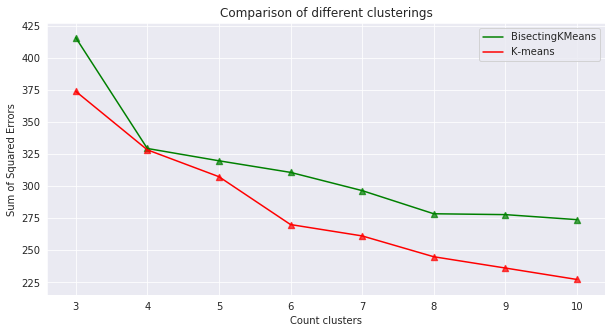

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(N_CLUSTERS_RANGE, bisect_k_means_costs, color='green')
plt.scatter(N_CLUSTERS_RANGE, bisect_k_means_costs, color='green', marker='^', alpha=0.7, linewidths=1.4)

plt.plot(N_CLUSTERS_RANGE, k_means_costs, color='red')
plt.scatter(N_CLUSTERS_RANGE, k_means_costs, color='red', marker='^', alpha=0.7, linewidths=1.4)

plt.xlabel('Count clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Comparison of different clusterings')
plt.legend(['BisectingKMeans', 'K-means'])
plt.xticks(N_CLUSTERS_RANGE)
plt.show()

### K-means:

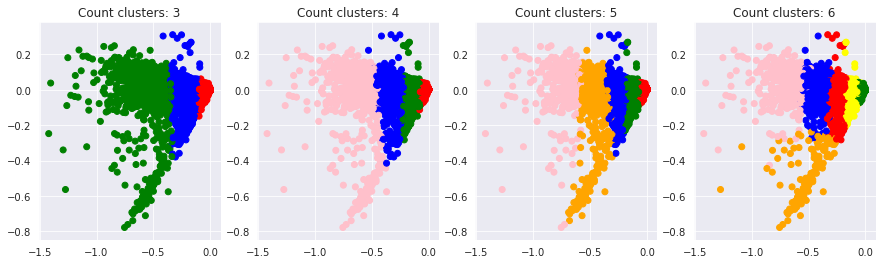

In [20]:
def get_pca_for_visualise(clusstering_model):
    labels = clusstering_model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))

    pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
    model = pca.fit(scaled_features)

    compressed = model.transform(scaled_features).select("pcaFeatures")
    compressed = compressed.toPandas()
    compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
    compressed = compressed.pcaFeatures.values
    compressed = np.stack(compressed, axis=0)

    colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'pink', 4:'orange', 5:'yellow'}
    colors = list(map(lambda x: colors[x], labels))
    return compressed.T, colors

plt.figure(figsize=(15, 4))

N_CLUSTERS_VIS = [3,4,5,6]
for i, cl in enumerate(N_CLUSTERS_VIS):
    points, colors = get_pca_for_visualise(k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*points, c=colors)
    plt.title('Count clusters: ' + str(cl))

plt.show()

### Bisect K-means:

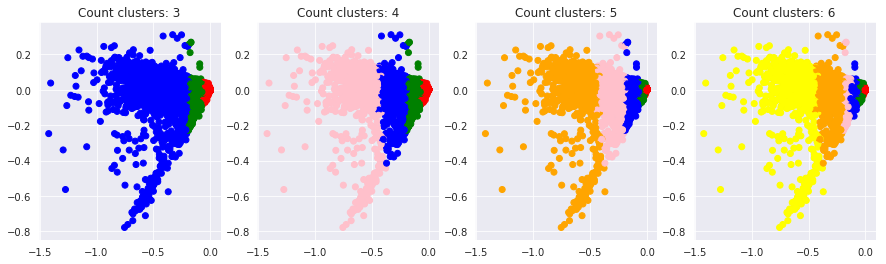

In [21]:
plt.figure(figsize=(15, 4))

for i, cl in enumerate(N_CLUSTERS_VIS):
    points, colors = get_pca_for_visualise(bisect_k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*points, c=colors)
    plt.title('Count clusters: ' + str(cl))
    
plt.show()

In [22]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib._color_data as mcd


df_data_for_tsne = df_features.toPandas()[features_names]
embedded_tsne = TSNE(n_components=2).fit_transform(df_data_for_tsne.values)


def colors_for_tsne(clusstering_model):
    labels = clusstering_model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))
    colors = dict(zip(range(len(list(mcd.CSS4_COLORS.keys())[20:] )), list(mcd.CSS4_COLORS.keys())[20:] ))
    colors = list(map(lambda x: colors[x], labels))    
    return colors

### K-means on t-SNE:

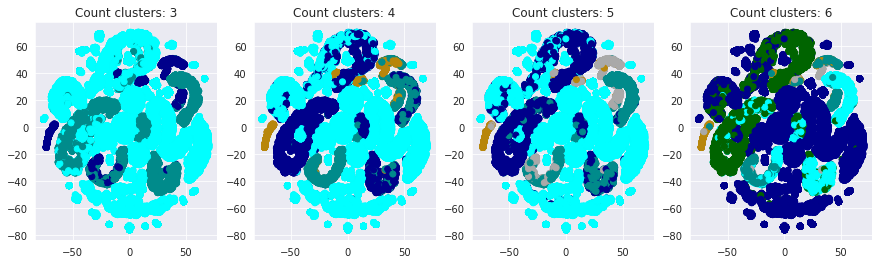

In [23]:
plt.figure(figsize=(15, 4))

for i, cl in enumerate(N_CLUSTERS_VIS):
    colors = colors_for_tsne(k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*embedded_tsne.T, c=colors)
    plt.title('Count clusters: ' + str(cl))
    
plt.show()

### Bisect K-means on t-SNE:

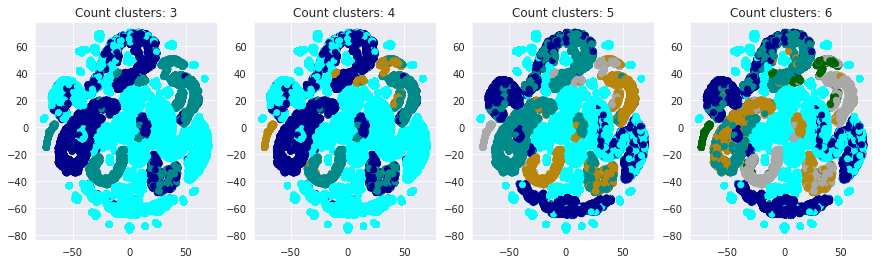

In [24]:
plt.figure(figsize=(15, 4))

for i, cl in enumerate(N_CLUSTERS_VIS):
    colors = colors_for_tsne(bisect_k_means_models[cl])
    plt.subplot(1, len(N_CLUSTERS_VIS), i+1)
    plt.scatter(*embedded_tsne.T, c=colors)
    plt.title('Count clusters: ' + str(cl))
    
plt.show()

### Evaluation

We've chosen a **Silhouette coefficient** to measure how appropriately data have been clustered.

For each point a Silhouette coefficient $s(i)$ is calculated using:
- mean intra-cluster distance $a(i)$

\begin{equation}
a(i)=\frac{1}{\left|C_{i}\right|-1} \sum_{j \in C_{i}, i \neq j} d(i, j)
\end{equation}

- mean nearest-cluster distance $b(i)$:

\begin{equation}
b(i)=\min _{k \neq i} \frac{1}{\left|C_{k}\right|} \sum_{j \in C_{k}} d(i, j)
\end{equation}

- $a(i)$ and $b(i)$ are combined in the following way:

\begin{equation}
s(i)=\left\{\begin{array}{ll}{1-a(i) / b(i),} & {\text { if } a(i)<b(i)} \\ {0,} & {\text { if } a(i)=b(i)} \\ {b(i) / a(i)-1,} & {\text { if } a(i)>b(i)}\end{array}\right.
\end{equation}


So the score $s(i)$ is between $-1$ and $1$

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score

def get_silhouette_avg(model):
    labels = model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))
    silhouette_avg = silhouette_score(df_data_for_tsne, labels)
    return silhouette_avg

silhouette_avg_kmeans = []
silhouette_avg_kmeans_bisec = []

for count_clusters in N_CLUSTERS_RANGE:
    silhouette_avg_kmeans.append(get_silhouette_avg(k_means_models[count_clusters]))
    silhouette_avg_kmeans_bisec.append(get_silhouette_avg(bisect_k_means_models[count_clusters]))

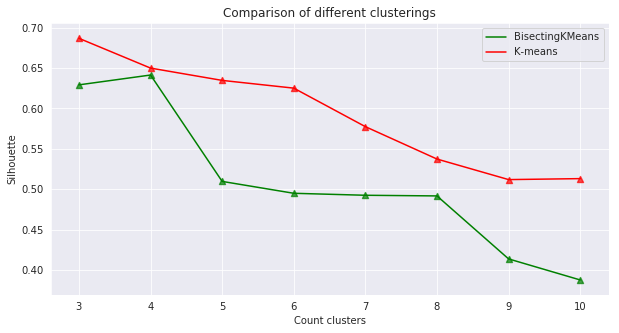

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(N_CLUSTERS_RANGE, silhouette_avg_kmeans_bisec, color='green')
plt.scatter(N_CLUSTERS_RANGE, silhouette_avg_kmeans_bisec, color='green', marker='^', alpha=0.7, linewidths=1.4)

plt.plot(N_CLUSTERS_RANGE, silhouette_avg_kmeans, color='red')
plt.scatter(N_CLUSTERS_RANGE, silhouette_avg_kmeans, color='red', marker='^', alpha=0.7, linewidths=1.4)

plt.xlabel('Count clusters')
plt.ylabel('Silhouette')
plt.title('Comparison of different clusterings')
plt.legend(['BisectingKMeans', 'K-means'])
plt.xticks(N_CLUSTERS_RANGE)
plt.show()

### Testing our framework

In [8]:
# test_article("Principal component analysis")
test_article("PCA")

It's a disambiguation. Please specify the request: Principal component analysis
- the references distribution:
  >   76% scientific papers (journals, publications, etc)
  >   12% books
  >   12% internet resources (news, archive, etc)
  >    0% media materials (prints)
- this article has a good amount of content and references


### Future work: 

* Create supervised machine learning model with ORES as labels and our features as inputs. The resulted model should be transferred to the other languages that didn’t support by ORES (like Ukrainian) <br><br> 

* Test the PySpark MLP / Random Forest / Gradient boosting and get the features importance (visualize the pluses and minuses of the articles references) <br><br>


### References

[1] Karypis, M.S.G., Kumar, V.: A comparison of document clustering techniques